# Evaluating data from HDF files

## Setup

### Importing base libraries

In [1]:
import os, sys

from tqdm.notebook import tqdm
from typing import List, Dict

import pandas as pd
import numpy as np
import networkx as nx

import plotly.express as px
import plotly.io as pio

pio.templates.default = 'seaborn'

In [2]:
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))

### Fetch data

In [3]:
from utils import CONNECTION_DIR, DATA_FOLDERS, FILES, fetch_data, preprocess, create_dataset

lesions = pd.read_csv(os.path.join(CONNECTION_DIR, DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['lesions']))

In [4]:
labels, lesions, patients = fetch_data()

X_train, X_test, y_train, y_test = \
    preprocess(labels, lesions, patients)

/Users/adhaene/miniconda3/envs/ds/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/adhaene/miniconda3/envs/ds/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
dataset_train = create_dataset(X=X_train, Y=y_train, dense=False, distance=1.0, connectivity='wasserstein')

In [6]:
dataset_train_old = create_dataset(X=X_train, Y=y_train, dense=False, distance=1.0, connectivity='wasserstein-old')

In [7]:
len(dataset_train), len(dataset_train_old)

(63, 70)

In [11]:
dataset_train[0].edge_index

tensor([[ 1,  1,  1,  ..., 73, 75, 75],
        [ 5,  8, 10,  ..., 72, 72, 73]])

In [21]:
X, Y = X_train, y_train

distance = 1.0

lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['lesions']))
# Filter out benign lesions and non-post-1 studies
lesions = lesions[(lesions.pars_classification_petct != 'benign') & (lesions.study_name == 'post-01')]
radiomics = pd.read_csv(os.path.join(CONNECTION_DIR, DATA_FOLDERS[3],
                                        FILES[DATA_FOLDERS[3]]['radiomics']))
radiomics['study_name'] = radiomics.study_name.apply(lambda sn: '-'.join(sn[1:].split('_')))
radiomics_features = ['vol_ccm', 'max_suv_val', 'mean_suv_val', 'min_suv_val', 'sd_suv_val']
lesions.drop(columns=radiomics_features, inplace=True)
lesions = lesions.merge(radiomics, on=['gpcr_id', 'study_name', 'lesion_label_id'], how='inner')

distances = pd.read_csv(os.path.join(CONNECTION_DIR, DATA_FOLDERS[3],
                                        FILES[DATA_FOLDERS[3]]['distances']))

# Get rid of invalid distances
valid_lesions_per_patient = lesions.groupby('gpcr_id').lesion_label_id.unique().to_dict()

dense = False

def is_valid_distance(row):

    valid_lesions = valid_lesions_per_patient.get(int(row.gpcr_id))
    
    if valid_lesions is None:
        return False

    intersection = set(valid_lesions) & set([row.lesion_i, row.lesion_j])
    
    return len(intersection) == 2

distances['valid'] = distances.apply(is_valid_distance, axis=1)
distances = distances[distances.valid]

dataset = []

if dense:
    max_num_nodes = lesions.groupby('gpcr_id').size().max()
    to_dense = ToDense(max_num_nodes)

patient = list(X.index.unique())[1]

# Create patient sub-DataFrame of all his post-1 study lesions
pdf = lesions[lesions.gpcr_id == patient].reset_index()

# Sanity check
assert pdf.shape[0] == X[X.index == patient].shape[0], f'Unequal lesion count for patient {patient}'

num_nodes = pdf.shape[0]
edge_index = []

wanted_edges = distances[(distances.gpcr_id == patient) \
                            & (distances.wasserstein_distance < distance)]
edge_index = wanted_edges[['lesion_i', 'lesion_j']].to_numpy().astype(int)
# Add edges in both directions
edge_index = np.concatenate([edge_index, np.flip(edge_index, axis=1)])

In [24]:
edge_index

array([[ 7, 26],
       [ 7, 33],
       [26, 33],
       [26,  7],
       [33,  7],
       [33, 26]])

In [30]:
k, v = pdf.lesion_label_id, pdf.index

mapping_ar = np.zeros(k.max() + 1, dtype=v.dtype)
mapping_ar[k] = v

mapping_ar[edge_index]

array([[1, 2],
       [1, 3],
       [2, 3],
       [2, 1],
       [3, 1],
       [3, 2]])

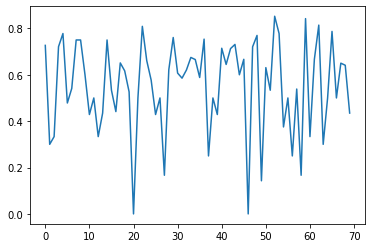

In [21]:
x, x_ = \
    list(map(lambda d: d.edge_index.shape[1], dataset_train)), list(map(lambda d: d.edge_index.shape[1], dataset_train_old))
y = range(len(dataset_train))

import matplotlib.pyplot as plt

plt.plot(y, np.array(x) / np.array(x_))

In [22]:
dataset_train_old

[Data(x=[60, 44], edge_index=[2, 2089], y=[1], num_nodes=60),
 Data(x=[4, 44], edge_index=[2, 10], y=[1], num_nodes=4),
 Data(x=[3, 44], edge_index=[2, 9], y=[1], num_nodes=3),
 Data(x=[23, 44], edge_index=[2, 190], y=[1], num_nodes=23),
 Data(x=[17, 44], edge_index=[2, 135], y=[1], num_nodes=17),
 Data(x=[7, 44], edge_index=[2, 23], y=[1], num_nodes=7),
 Data(x=[15, 44], edge_index=[2, 194], y=[1], num_nodes=15),
 Data(x=[11, 44], edge_index=[2, 36], y=[1], num_nodes=11),
 Data(x=[4, 44], edge_index=[2, 4], y=[1], num_nodes=4),
 Data(x=[4, 44], edge_index=[2, 10], y=[1], num_nodes=4),
 Data(x=[7, 44], edge_index=[2, 49], y=[1], num_nodes=7),
 Data(x=[5, 44], edge_index=[2, 20], y=[1], num_nodes=5),
 Data(x=[3, 44], edge_index=[2, 3], y=[1], num_nodes=3),
 Data(x=[14, 44], edge_index=[2, 92], y=[1], num_nodes=14),
 Data(x=[16, 44], edge_index=[2, 116], y=[1], num_nodes=16),
 Data(x=[12, 44], edge_index=[2, 30], y=[1], num_nodes=12),
 Data(x=[9, 44], edge_index=[2, 34], y=[1], num_nodes

In [8]:
from torch_geometric.loader import DataLoader

dataloader = DataLoader(dataset=dataset_train, batch_size=4)

In [46]:
dataset_train

[Data(x=[60, 44], edge_index=[2, 329], y=[1], num_nodes=60),
 Data(x=[4, 44], edge_index=[2, 1], y=[1], num_nodes=4),
 Data(x=[3, 44], edge_index=[2, 0], y=[1], num_nodes=3),
 Data(x=[23, 44], edge_index=[2, 21], y=[1], num_nodes=23),
 Data(x=[17, 44], edge_index=[2, 18], y=[1], num_nodes=17),
 Data(x=[7, 44], edge_index=[2, 1], y=[1], num_nodes=7),
 Data(x=[15, 44], edge_index=[2, 32], y=[1], num_nodes=15),
 Data(x=[11, 44], edge_index=[2, 2], y=[1], num_nodes=11),
 Data(x=[4, 44], edge_index=[2, 0], y=[1], num_nodes=4),
 Data(x=[4, 44], edge_index=[2, 3], y=[1], num_nodes=4),
 Data(x=[7, 44], edge_index=[2, 17], y=[1], num_nodes=7),
 Data(x=[5, 44], edge_index=[2, 1], y=[1], num_nodes=5),
 Data(x=[3, 44], edge_index=[2, 0], y=[1], num_nodes=3),
 Data(x=[14, 44], edge_index=[2, 15], y=[1], num_nodes=14),
 Data(x=[16, 44], edge_index=[2, 14], y=[1], num_nodes=16),
 Data(x=[12, 44], edge_index=[2, 4], y=[1], num_nodes=12),
 Data(x=[9, 44], edge_index=[2, 2], y=[1], num_nodes=9),
 Data(x

In [24]:
distances = pd.read_csv(os.path.join(CONNECTION_DIR, DATA_FOLDERS[3],
                                         FILES[DATA_FOLDERS[3]]['distances']))

In [25]:
lesions = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['lesions']))
# Filter out benign lesions and non-post-1 studies
lesions = lesions[(lesions.pars_classification_petct != 'benign') & (lesions.study_name == 'post-01')]
radiomics = pd.read_csv(os.path.join(CONNECTION_DIR, DATA_FOLDERS[3],
                                        FILES[DATA_FOLDERS[3]]['radiomics']))
radiomics['study_name'] = radiomics.study_name.apply(lambda sn: '-'.join(sn[1:].split('_')))
radiomics_features = ['vol_ccm', 'max_suv_val', 'mean_suv_val', 'min_suv_val', 'sd_suv_val']
lesions.drop(columns=radiomics_features, inplace=True)
lesions = lesions.merge(radiomics, on=['gpcr_id', 'study_name', 'lesion_label_id'], how='inner')

In [26]:
valid_lesions_per_patient = lesions.groupby('gpcr_id').lesion_label_id.unique().to_dict()

In [27]:
def is_valid_distance(row):
    
    valid_lesions = valid_lesions_per_patient.get(int(row.gpcr_id))
    
    if valid_lesions is None:
        return False

    intersection = set(valid_lesions) & set([row.lesion_i, row.lesion_j])
    
    return len(intersection) == 2

In [28]:
distances['valid'] = distances.apply(is_valid_distance, axis=1)

In [29]:
distances[distances.valid]

,gpcr_id,lesion_i,lesion_j,wasserstein_distance,valid
630,34610002.0,1.0,2.0,1.669488,True
631,34610002.0,1.0,3.0,1.496118,True
632,34610002.0,1.0,4.0,1.434918,True
633,34610002.0,1.0,5.0,0.235000,True
634,34610002.0,1.0,6.0,1.555574,True
...,...,...,...,...,...
447878,34610148.0,19.0,46.0,5.507947,True
447888,34610148.0,19.0,56.0,2.503401,True
448386,34610148.0,27.0,46.0,6.077701,True
448396,34610148.0,27.0,56.0,3.073155,True


In [32]:
h = distances[(distances.gpcr_id == 34610001) & (distances.wasserstein_distance < 0.5)][['lesion_i', 'lesion_j']] \
    .to_numpy().astype(int)

In [41]:
np.concatenate([h[:3,:], np.flip(h, axis=1)[:3,:]])


array([[ 2, 16],
       [ 3, 14],
       [ 3, 16],
       [16,  2],
       [14,  3],
       [16,  3]])

In [6]:
labels, lesions, patients = fetch_data()

In [11]:
import plotly.express as px

px.scatter(lesions, x='mean_suv_val', y='sd_suv_val')

In [ ]:

# Keep only radiomics features and assigned organ
lesions = lesions[['gpcr_id', 'study_name', *radiomics_features, 'assigned_organ']]

In [36]:
patients = pd.read_csv(os.path.join(CONNECTION_DIR + DATA_FOLDERS[2], FILES[DATA_FOLDERS[2]]['patients']))
patients.shape

(133, 9)

In [54]:
lesions.groupby(['gpcr_id', 'study_name']).lesion_label_id.count().describe()

count    504.000000
mean      42.079365
std       38.380092
min        3.000000
25%       16.000000
50%       29.000000
75%       54.250000
max      202.000000
Name: lesion_label_id, dtype: float64

/Users/arnauddhaene/miniconda3/envs/ds/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='lesion_label_id'>

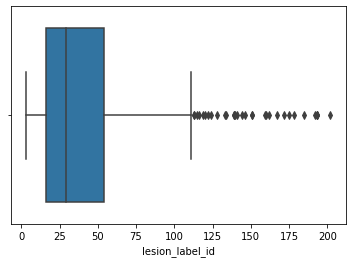

In [55]:
import seaborn as sns

sns.boxplot(lesions.groupby(['gpcr_id', 'study_name']).lesion_label_id.count())